# Anomaly Detection by Abdullah Saka

**Packages used: Pandas, Numpy, Seaborn, Sklearn, Xgboost and Plotly**

In [1]:
#import packages
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import plotly.express as px
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score,matthews_corrcoef,classification_report, confusion_matrix,plot_precision_recall_curve

In [2]:
# location of train_numeric file
path_numeric="~/bosch_iot/train_numeric.csv"

In [3]:
def import_data(path):
    dfList = []
    df=pd.DataFrame()
    for iot_chunk in pd.read_csv(path,chunksize=100000):
        dfList.append(iot_chunk)
    df = pd.concat(dfList,sort=False)
    return df

In [4]:
#apply import_data function
df_numeric=import_data(path_numeric)

In [5]:
# take Response column from the dataset
Response=df_numeric[['Response']]

In [6]:
# drop Response variable from the dataset
df_numeric.drop(['Response'],axis=1,inplace=True)

In [7]:
# remove null observations from numeric data
df_numeric=df_numeric.dropna(thresh=2,axis=0)

In [8]:
# dimension of the numerical dataset
df_numeric.shape

(1183165, 969)

In [9]:
# check first 5 observations
df_numeric.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


-------

# Sampling

**I applied undersampling by keeping all failed observations (minor class) and taking a sample from successful observations (major class)**

In [10]:
# combine numeric dataset with Response
df_numeric=pd.concat([df_numeric,Response],axis=1)
df_numeric.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4.0,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7.0,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9.0,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11.0,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [11]:
# seperate the dataframe based on Response
df_major=df_numeric[df_numeric.Response==0] 
df_minor=df_numeric[df_numeric.Response==1]

In [12]:
# take a sample from major class(1)
df_major_sample=df_major.sample(frac=0.022,random_state=21)

In [13]:
# combine major and minor class
df_numericz=pd.concat([df_major_sample,df_minor])

In [14]:
# take part IDs
part_id=df_numericz[['Id']]
part_id=part_id.reset_index(drop=True)
part_id.head(3)

,Id
0,153766.0
1,118415.0
2,161414.0


-----

# Data Manipulation on Numeric File

In [15]:
# take features related to Line 3
features_line3=np.array(df_numericz.columns[df_numericz.columns.str.contains('L3_')])

In [16]:
# also append Response
features = np.append(features_line3,['Response'])

In [17]:
# also add ID
features = np.append(['Id'],features)

In [18]:
# take the dataframe including Line 3 sensors
df_line3=df_numericz[features]
df_line3.head()

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
76768,153766.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0
59154,118415.0,-0.216,0.077,-0.099,0.070,-0.060,-0.050,-0.006,0.006,-0.064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
80496,161414.0,0.252,-0.190,-0.201,-0.137,0.104,0.093,0.113,0.090,0.157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
576934,1154864.0,-0.014,0.026,-0.229,-0.057,0.022,-0.004,0.006,-0.105,0.079,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
996875,1993876.0,-0.165,0.227,0.008,-0.163,-0.021,-0.017,-0.119,-0.105,0.102,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [19]:
# make a copy
df=df_line3.copy()

In [20]:
df_upd=df.iloc[:,1:-1]
df_upd.head()

,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,...,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
76768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
59154,-0.216,0.077,-0.099,0.070,-0.060,-0.050,-0.006,0.006,-0.064,-0.081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80496,0.252,-0.190,-0.201,-0.137,0.104,0.093,0.113,0.090,0.157,0.185,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
576934,-0.014,0.026,-0.229,-0.057,0.022,-0.004,0.006,-0.105,0.079,0.109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996875,-0.165,0.227,0.008,-0.163,-0.021,-0.017,-0.119,-0.105,0.102,0.106,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# fill NA values for train dataset
df_filled=df_upd.apply(lambda column: column.fillna(column.mean(),axis=0))

In [22]:
# check first 5 obervations
pd.set_option('display.max_columns', None)
df_filled.head()

,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,L3_S29_F3345,L3_S29_F3348,L3_S29_F3351,L3_S29_F3354,L3_S29_F3357,L3_S29_F3360,L3_S29_F3367,L3_S29_F3370,L3_S29_F3373,L3_S29_F3376,L3_S29_F3379,L3_S29_F3382,L3_S29_F3385,L3_S29_F3388,L3_S29_F3395,L3_S29_F3398,L3_S29_F3401,L3_S29_F3404,L3_S29_F3407,L3_S29_F3412,L3_S29_F3421,L3_S29_F3424,L3_S29_F3427,L3_S29_F3430,L3_S29_F3433,L3_S29_F3436,L3_S29_F3439,L3_S29_F3442,L3_S29_F3449,L3_S29_F3452,L3_S29_F3455,L3_S29_F3458,L3_S29_F3461,L3_S29_F3464,L3_S29_F3467,L3_S29_F3470,L3_S29_F3473,L3_S29_F3476,L3_S29_F3479,L3_S29_F3482,L3_S29_F3485,L3_S29_F3488,L3_S29_F3491,L3_S30_F3494,L3_S30_F3499,L3_S30_F3504,L3_S30_F3509,L3_S30_F3514,L3_S30_F3519,L3_S30_F3524,L3_S30_F3529,L3_S30_F3534,L3_S30_F3539,L3_S30_F3544,L3_S30_F3549,L3_S30_F3554,L3_S30_F3559,L3_S30_F3564,L3_S30_F3569,L3_S30_F3574,L3_S30_F3579,L3_S30_F3584,L3_S30_F3589,L3_S30_F3594,L3_S30_F3599,L3_S30_F3604,L3_S30_F3609,L3_S30_F3614,L3_S30_F3619,L3_S30_F3624,L3_S30_F3629,L3_S30_F3634,L3_S30_F3639,L3_S30_F3644,L3_S30_F3649,L3_S30_F3654,L3_S30_F3659,L3_S30_F3664,L3_S30_F3669,L3_S30_F3674,L3_S30_F3679,L3_S30_F3684,L3_S30_F3689,L3_S30_F3694,L3_S30_F3699,L3_S30_F3704,L3_S30_F3709,L3_S30_F3714,L3_S30_F3719,L3_S30_F3724,L3_S30_F3729,L3_S30_F3734,L3_S30_F3739,L3_S30_F3744,L3_S30_F3749,L3_S30_F3754,L3_S30_F3759,L3_S30_F3764,L3_S30_F3769,L3_S30_F3774,L3_S30_F3779,L3_S30_F3784,L3_S30_F3789,L3_S30_F3794,L3_S30_F3799,L3_S30_F3804,L3_S30_F3809,L3_S30_F3814,L3_S30_F3819,L3_S30_F3824,L3_S30_F3829,L3_S31_F3834,L3_S31_F3838,L3_S31_F3842,L3_S31_F3846,L3_S32_F3850,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S35_F3884,L3_S35_F3889,L3_S35_F3894,L3_S35_F3896,L3_S35_F3898,L3_S35_F3903,L3_S35_F3908,L3_S35_F3913,L3_S36_F3918,L3_S36_F3920,L3_S36_F3922,L3_S36_F3924,L3_S36_F3926,L3_S36_F3930,L3_S36_F3934,L3_S36_F3938,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,L3_S38_F3952,L3_S38_F3956,L3_S38_F3960,L3_S39_F3964,L3_S39_F3968,L3_S39_F3972,L3_S39_F3976,L3_S40_F3980,L3_S40_F3982,L3_S40_F3984,L3_S40_F3986,L3_S40_F3988,L3_S40_F3990,L3_S40_F3992,L3_S40_F3994,L3_S41_F3996,L3_S41_F3998,L3_S41_F4000,L3_S41_F4002,L3_S41_F4004,L3_S41_F4006,L3_S41_F4008,L3_S41_F4011,L3_S41_F4014,L3_S41_F4016,L3_S41_F4018,L3_S41_F4020,L3_S41_F4023,L3_S41_F4026,L3_S43_F4060,L3_S43_F4065,L3_S43_F4070,L3_S43_F4075,L3_S43_F4080,L3_S43_F4085,L3_S43_F4090,L3_S43_F4095,L3_S44_F4100,L3_S44_F4103,L3_S44_F4106,L3_S44_F4109,L3_S44_F4112,L3_S44_F4115,L3_S44_F4118,L3_S44_F4121,L3_S45_F4124,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4173,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4200,L3_S48_F4202,L3_S48_F4204,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4226,L3_S49_F4231,L3_S49_F4236,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
76768,-0.001764,-0.001493,0.000502,-0.000333,0.001232,0.000885,0.000528,0.000585,0.005541,0.005524,-0.001846,-0.003318,-0.010216,-0.003274,-0.001423,-0.000185,-0.000333,0.000585,-0.002456,0.000793,0.003065,0.000342,0.000502,0.000528,-0.003318,-0.000185,-0.001846,-0.001423,0.004584,0.004584,-0.001493,0.000885,-0.000107,0.001269,-0.001032,0.000899,-0.001764,0.001232,0.005524,-0.003274,0.005541,-0.010216,0.001516,0.024565,0.001516,0.024565,0.000256,0.000258,0.001342,-0.000086,0.000006,0.000052,0.000062,0.000203,0.000203,0.000019,-0.000129,-0.000952,-0.002776,0.00004,0.000019,0.001143,-0.000952,0.000169,0.00004,0.000843,0.001143,0.00003,-0.001699,0.001682,-0.00098,0.00016,0.00055,-0.00009,-0.00009,-0.000229,0.000773,-0.00009,-0.00009,0.000011,0.000631,-0.000023,0.000871,-0.000091,0.00088,-0.00009,-0.00009,0

# Anomaly Detection Analysis

In [23]:
# calculate mean of each sensors in the production line 3
mean_line3=pd.DataFrame(df_upd.mean(axis=0)).reset_index()

In [24]:
# calculate stdev of each sensors in the production line 3
stdev_line3=pd.DataFrame(df_upd.std(axis=0)).reset_index()

In [25]:
# rename columns of mean
mean_line3.columns=['feature','mean']

In [26]:
# rename columns of stdev
stdev_line3.columns=['feature','stdev']

In [27]:
# merge mean and stdev dataframe
description=mean_line3.merge(stdev_line3,how='left',on='feature')

In [28]:
# compute max threshold
description['max_thresh']=description['mean']+(2*description['stdev'])

In [29]:
# compute min threshold
description['min_thresh']=description['mean']-(2*description['stdev'])

In [30]:
# manually check one example
#len(df_filled[(df_filled['L3_S29_F3318']>0.185304) | (df_filled['L3_S29_F3318']<-0.188290)])

In [31]:
# run for loop to calculate how many part are except between min and max threshold
q=[]
for i in range(len(description)):
    value=len(df_filled[(df_filled.iloc[:,i]>description['max_thresh'].iloc[i]) | (df_filled.iloc[:,i]<description['min_thresh'].iloc[i])])
    q.append(value)

In [32]:
# add array was built above to description dataframe
description['outliers']=q

In [33]:
# define error_rate in terms of percent
description['error_rate']=(description['outliers']/len(df_filled))*100

In [34]:
# sort dataframe by error_rate
description.sort_values(by='error_rate',ascending=False,inplace=True)

In [35]:
# reset index and see first 5 observations
description=description.reset_index(drop=True)
description.head()

,feature,mean,stdev,max_thresh,min_thresh,outliers,error_rate
0,L3_S29_F3461,0.001516,0.155815,0.313146,-0.310113,2703,8.248398
1,L3_S29_F3467,0.001516,0.155815,0.313146,-0.310113,2703,8.248398
2,L3_S30_F3544,0.000169,0.014404,0.028977,-0.028638,2563,7.821178
3,L3_S29_F3357,-0.001423,0.096080,0.190737,-0.193583,2463,7.516021
4,L3_S29_F3404,-0.001423,0.096080,0.190737,-0.193583,2463,7.516021


In [36]:
# create simple dataframe to analyze anomalies
sub=description[['feature','error_rate']]
sub.columns=['feature','error_percent']
sub.iloc[10:20]

,feature,error_percent
10,L3_S29_F3333,5.032042
11,L3_S30_F3509,4.855050
12,L3_S29_F3370,4.830638
13,L3_S29_F3336,4.830638
14,L3_S30_F3754,4.659750
15,L3_S29_F3382,4.644492
16,L3_S30_F3744,4.595667
17,L3_S30_F3499,4.372902
18,L3_S30_F3494,4.372902
19,L3_S30_F3554,4.220323


In [37]:
# write to csv
#description.to_csv('error.csv')

[Text(0, 0.5, 'Freq')]

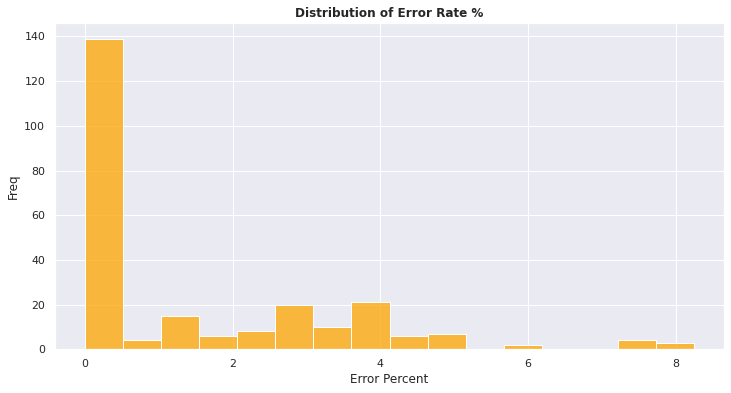

In [41]:
# visualize error_rate by using the histogram
sns.set()
plt.figure(figsize=(12, 6))
plt.title('Distribution of Error Rate %', weight='bold')
ax=sns.histplot(data=description, x="error_rate", color='orange',bins=16)
ax.set(xlabel='Error Percent')
ax.set(ylabel='Freq')

**!! Stations 29 & 30 have higher error rate than others; hence they should be controlled to decrease anomalies**